# Clustering ATMs

In this notebook, I will pick n atm ids (n=50) and generate a dataset for clustering.

In [138]:
import matplotlib.pyplot as plt

sys.path.append(r'../atm_demand')
from feature_generation import *
from models import *

import pandas as pd
import tensorflow as tf
from scipy.special import softmax
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [139]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")

In [140]:
df['AtmId'].value_counts()[:50].index

Int64Index([ 26637,  27687,  27663,  33817,  33821,  27651,  32785,  33793,
             33795,  33796, 119852,  33800,  27664,  27667,  33807,  33850,
             33774,  33852,  27711,  33827,  33828,  33830,  27707,  33831,
             33833,  27727,  27723,  33879,  27714,  33862,  33809,  33771,
             27729,  27570,  27537,  33677,  27539,  33679,  33713,  33714,
             27556,  33724,  33726,  27579,  33707,  27568,  33711, 119801,
             33766,  33750],
           dtype='int64')

## Generating Datasets with Data of All ATMs

In [141]:
CLUSTER_WITH = 'CashIn'

clustering_df = pd.DataFrame(dtype='float64')
feature_sets = []
atmIds = df['AtmId'].value_counts()[:50].index


for atmId in atmIds:
    atm_df = get_atm(df, atmId)
    atm_df = atm_df[:-135]
    atm_df = clean_data(atm_df, drop_zeros=True)
    
    #for target in ['CashIn', 'CashOut']:
    #    atm_df[target] = np.log(atm_df[target] + 1e-6)

    day_of_the_week_index = get_day_of_the_week_index(atm_df.index)

    for i in range(7):
        clustering_df.loc[atmId, i] = atm_df.loc[day_of_the_week_index[day_of_the_week_index == i].index].mean()[CLUSTER_WITH]

    atm_df['AtmId'] = atmId
    feature_set = get_feature_sets(atm_df, ['CashIn', 'CashOut'])
    feature_sets.append(feature_set)

all_atms_feature_set = pd.concat(feature_sets, axis=0)

## Applying Kmeans and Updating the Dataset

In [142]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(softmax(np.log(clustering_df.to_numpy()), axis=1))

d = {atmId:label for atmId, label in zip(atmIds, kmeans.labels_)}

all_atms_feature_set['ClusterId'] = all_atms_feature_set['AtmId'].map(d)
all_atms_feature_set.sort_index(inplace = True)
all_atms_feature_set

,CashIn,CashOut,AtmId,CashIn_average_7,CashIn_average_30,CashOut_average_7,CashOut_average_30,CashIn_trend_7,CashOut_trend_7,CashIn_t-1,...,ramazan_in_7_days,is_kurban,kurban_in_7_days,is_cocuk_bayrami,is_isci_bayrami,is_spor_bayrami,is_zafer_bayrami,is_cumhuriyet_bayrami,Special_Dates_Index,ClusterId
HistoryDate,,,,,,,,,,,,,,,,,,,,,
2016-02-10,55320.0,36480.0,26637,56012.857143,55019.000000,49010.000000,42199.333333,119250.0,60210.0,46460.0,...,0,0,0,0,0,0,0,0,0,1
2016-02-10,15000.0,53750.0,33821,24338.571429,21724.666667,39934.285714,28915.000000,38150.0,27240.0,21910.0,...,0,0,0,0,0,0,0,0,0,4
2016-02-10,56950.0,50690.0,27570,53068.571429,55690.666667,50448.571429,41369.666667,74410.0,29840.0,60450.0,...,0,0,0,0,0,0,0,0,0,5
2016-02-10,22490.0,18690.0,27537,16298.571429,15460.333333,25232.857143,19246.333333,25260.0,22530.0,20070.0,...,0,0,0,0,0,0,0,0,0,2
2016-02-10,32700.0,51560.0,33677,29270.000000,30223.666667,32550.000000,24693.000000,-9050.0,29160.0,28460.0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-22,48025.0,59900.0,33831,54140.714286,50942.000000,72208.571429,75700.333333,28380.0,38270.0,66510.0,...,0,0,0,0,0,0,0,0,0,6
2020-01-22,70900.0,37100.0,33833,72915.714286,72119.500000,50164.285714,42285.333333,109455.0,59850.0,71905.0,...,0,0,0,0,0,0,0,0,0,2
2020-01-22,90185.0,62980.0,27727,96818.571429,100188.666667,65081.428571,77260.666667,228080.0,59420.0,74500.0,...,0,0,0,0,0,0,0,0,0,6


## Aranging Data for Model Training

In [143]:
all_atms_feature_set.columns

Index(['CashIn', 'CashOut', 'AtmId', 'CashIn_average_7', 'CashIn_average_30',
       'CashOut_average_7', 'CashOut_average_30', 'CashIn_trend_7',
       'CashOut_trend_7', 'CashIn_t-1', 'CashIn_t-2', 'CashIn_t-3',
       'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6', 'CashIn_t-7', 'CashIn_t-8',
       'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11', 'CashIn_t-12',
       'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1', 'CashOut_t-2',
       'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5', 'CashOut_t-6',
       'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9', 'CashOut_t-10',
       'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13', 'CashOut_t-14',
       'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17', 'CashOut_t-18',
       'CashOut_t-19', 'CashOut_t-20', 'CashOut_t-21', 'CashOut_t-22',
       'CashOut_t-23', 'CashOut_t-24', 'CashOut_t-25', 'CashOut_t-26',
       'CashOut_t-27', 'CashOut_t-28', 'CashOut_t-29', 'CashOut_t-30',
       'CashOut_t-31', 'CashOut_t-32', 'CashOut_t-33', 'CashOut_t-34',
       'CashOut

In [144]:
categorical_features = ['Day_of_the_Week_Index', 'Day_of_the_Month_Index',
       'Week_of_the_Year_Index', 'Is_Weekday', 'Special_Dates_Index',
       'is_cocuk_bayrami', 'is_isci_bayrami', 'is_spor_bayrami',
       'is_zafer_bayrami', 'is_cumhuriyet_bayrami', 'ClusterId']
continuous_features   = ['CashIn_average_7', 'CashIn_average_30',
       'CashOut_average_7', 'CashOut_average_30', 'CashIn_trend_7',
       'CashOut_trend_7', 'CashIn_t-1', 'CashIn_t-2', 'CashIn_t-3',
       'CashIn_t-4', 'CashIn_t-5', 'CashIn_t-6', 'CashIn_t-7', 'CashIn_t-8',
       'CashIn_t-9', 'CashIn_t-10', 'CashIn_t-11', 'CashIn_t-12',
       'CashIn_t-13', 'CashIn_t-14', 'CashOut_t-1', 'CashOut_t-2',
       'CashOut_t-3', 'CashOut_t-4', 'CashOut_t-5', 'CashOut_t-6',
       'CashOut_t-7', 'CashOut_t-8', 'CashOut_t-9', 'CashOut_t-10',
       'CashOut_t-11', 'CashOut_t-12', 'CashOut_t-13', 'CashOut_t-14',
       'CashOut_t-15', 'CashOut_t-16', 'CashOut_t-17', 'CashOut_t-18',
       'CashOut_t-19', 'CashOut_t-20', 'CashOut_t-21', 'CashOut_t-22',
       'CashOut_t-23', 'CashOut_t-24', 'CashOut_t-25', 'CashOut_t-26',
       'CashOut_t-27', 'CashOut_t-28', 'CashOut_t-29', 'CashOut_t-30',
       'CashOut_t-31', 'CashOut_t-32', 'CashOut_t-33', 'CashOut_t-34',
       'CashOut_t-35', 'CashOut_t-36', 'CashOut_t-37', 'CashOut_t-38',
       'CashOut_t-39', 'CashOut_t-40']

groups = [continuous_features]
groups.extend(categorical_features)

TARGET = 'CashIn'
X_train, X_test, y_train, y_test = train_test_split(all_atms_feature_set[all_atms_feature_set.columns[2:]], all_atms_feature_set[TARGET], shuffle = False)

train_inputs = get_input_sets(X_train, groups)
test_inputs  = get_input_sets(X_test, groups)

## Training

In [145]:
tabTransforer = TabTransformer(
    categories = [len(all_atms_feature_set[categorical].unique()) for categorical in categorical_features],
    num_continuous = len(continuous_features),
    dim = 16,
    dim_out = 1,
    depth = 6,
    heads = 12,
    attn_dropout = 0.1,
    ff_dropout = 0.1,
    mlp_hidden = [(64, 'selu'), (16, 'selu')]
)

In [146]:
tabTransforer.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mape')

In [147]:
history = tabTransforer.fit(train_inputs, 
            y_train,
            batch_size=1024,
            epochs=100,
            validation_data=(test_inputs, y_test),
            verbose = 1)

Epoch 1/100
53/53 [==============================] - 68s 1s/step - loss: 99.6590 - val_loss: 95.6932
Epoch 2/100
53/53 [==============================] - 59s 1s/step - loss: 95.3032 - val_loss: 90.5546
Epoch 3/100
53/53 [==============================] - 59s 1s/step - loss: 85.7739 - val_loss: 89.4647
Epoch 4/100
53/53 [==============================] - 59s 1s/step - loss: 86.3051 - val_loss: 90.0937
Epoch 5/100
53/53 [==============================] - 60s 1s/step - loss: 84.6405 - val_loss: 91.0200
Epoch 6/100
53/53 [==============================] - 59s 1s/step - loss: 82.6521 - val_loss: 92.0470
Epoch 7/100
53/53 [==============================] - 58s 1s/step - loss: 82.0275 - val_loss: 98.2019
Epoch 8/100
53/53 [==============================] - 58s 1s/step - loss: 82.4567 - val_loss: 91.6053
Epoch 9/100
53/53 [==============================] - 57s 1s/step - loss: 81.7918 - val_loss: 88.9266
Epoch 10/100
53/53 [==============================] - 59s 1s/step - loss: 80.5910 - val_los

In [148]:
def plot_history(history):
    plt.figure(figsize=(10,4))
    for key in history.history:
        plt.plot(history.history[key][:], label = key)
    plt.legend()
    plt.show()

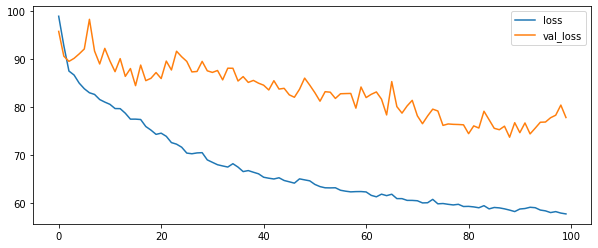

In [149]:
plot_history(history)

In [160]:
"min_loss: %.4f, min_val_loss: %.4f" % (min(history.history['loss']), min(history.history['val_loss']))

'min_loss: 57.7848, min_val_loss: 73.7140'

In [177]:
ATM_ID = 27568
atm_feature_set = all_atms_feature_set[all_atms_feature_set['AtmId'] == ATM_ID]
atm_feature_set

,CashIn,CashOut,AtmId,CashIn_average_7,CashIn_average_30,CashOut_average_7,CashOut_average_30,CashIn_trend_7,CashOut_trend_7,CashIn_t-1,...,ramazan_in_7_days,is_kurban,kurban_in_7_days,is_cocuk_bayrami,is_isci_bayrami,is_spor_bayrami,is_zafer_bayrami,is_cumhuriyet_bayrami,Special_Dates_Index,ClusterId
HistoryDate,,,,,,,,,,,,,,,,,,,,,
2016-02-10,78860.0,64950.0,27568,84277.142857,84736.333333,66850.000000,54594.666667,202730.0,94010.0,52630.0,...,0,0,0,0,0,0,0,0,0,0
2016-02-11,141390.0,87710.0,27568,73468.571429,85889.666667,65451.428571,54994.000000,47550.0,81350.0,78860.0,...,0,0,0,0,0,0,0,0,0,0
2016-02-12,87260.0,66370.0,27568,83050.000000,90358.000000,69565.714286,57741.666667,105820.0,165960.0,141390.0,...,0,0,0,0,0,0,0,0,0,0
2016-02-13,22900.0,74760.0,27568,85934.285714,88951.000000,63458.571429,58086.333333,63930.0,56380.0,87260.0,...,0,0,0,0,0,0,0,0,0,0
2016-02-14,97995.0,80695.0,27568,81191.428571,88507.000000,66717.142857,58696.333333,-17510.0,31700.0,22900.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-18,116770.0,120340.0,27568,163400.000000,156006.166667,143428.571429,124372.333333,152965.0,63020.0,161345.0,...,0,0,0,0,0,0,0,0,0,0
2020-01-19,93660.0,81420.0,27568,157249.285714,156557.000000,141747.142857,125565.000000,128885.0,25690.0,116770.0,...,0,0,0,0,0,0,0,0,0,0
2020-01-20,200380.0,116190.0,27568,152047.857143,154333.333333,140781.428571,125019.666667,131685.0,58640.0,93660.0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
from forecasting import get_error_with_freq
from plotting import draw_error_over_time

In [179]:
def draw_model_error(model, X, y_actual, error_freq='w', split_from=None):

    y_pred = pd.Series(model.predict(X).reshape(-1), index=y_actual.index)
    weekly_errors = get_error_with_freq(y_actual, y_pred, error_freq)
    draw_error_over_time(y_actual, y_pred, weekly_errors, split_from)
    print(weekly_errors.mean())

In [180]:
draw_model_error(tabTransforer, get_input_sets(atm_feature_set[atm_feature_set.columns[2:]], groups), atm_feature_set[TARGET], split_from=X_train.index[-1])

75.53127422146447
